<table>
    <tr style="background-color:white;">
        <td width="60%">
            <div style="height: 25px;"></div>
            <div align="left" style="color: #4b324e; font-size: 40px; font-weight: bold;">Taller de Qiskit</div>
        </td>
        <td>
            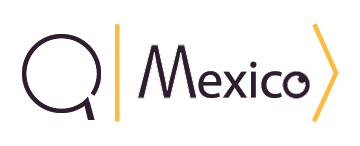
        </td>
    </tr>
</table>

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

<div align="center" style="color: #EE2A6F; font-size: 30px; font-weight: bold;">Ruido en los Experimentos</div>

<div align="right" style="font-size: 15px; font-weight: normal;">Preparado por Claudia Zendejas-Morales</div>

<a href="https://opensource.org/licenses/Apache-2.0"></a>

# Contenido

1. [Introducción](#intro)
   1. [Canal cuántico](#intro.1)
2. [Construir modelos de ruido](#secc1)
   1. [Errores cuánticos con Qiskit](#secc1.1)
      1. [Combinación de errores cuánticos](#secc1.1.1)
      2. [Ejemplo](#secc1.1.2)
      3. [Conversión a operadores QuantumChannel](#secc1.1.3)
      4. [Error de lectura](#secc1.1.4)
   2. [Agregar errores a un Modelo de Ruido](#secc1.2)
      1. [Error cuántico en todos los qubits](#secc1.2.1)
      2. [Error cuántico específico de un qubit](#secc1.2.2)
      3. [Error cuántico no local](#secc1.2.3)
   3. [Ejecutar un simulador ruidoso con un modelo de ruido](#secc1.3)
3. [Modelos de ruido en simuladores](#secc2)
   1. [Simulación ideal](#secc2.1)
   2. [Modelo básico de ruido para error de inversión de bits](#secc2.2)
   3. [Modelo de relajación térmica $T_1\;/\;T_2$](#secc2.3)
4. [Modelos de ruido obtenidos de los dispositivos reales](#secc3)
   1. [Backend de imitación de Terra](#secc3.1)
5. [Referencias](#secc4)

<a id="intro"></a>
# Introducción

¿Por qué hacer computadoras cuánticas es realmente difícil? Por el **ruido**. Cuando escuchamos esa palabra probablemente pensamos en sonidos fuertes como el ruido del tráfico que dificulta la concentración. Nos referimos a algo un poco diferente aquí; el ruido cuántico describe todas las cosas que causan interferencia en una computadora cuántica.

Al igual que una llamada de teléfono móvil puede sufrir interferencias que provocan que la llamada se interrumpa, una computadora cuántica es susceptible a interferencias de muchos tipos de fuentes, como señales electromagnéticas provenientes del Wi-Fi o perturbaciones en el campo magnético de la Tierra. Cuando los qubits en una computadora cuántica están expuestos a este tipo de ruido (campos externos), la información que contienen se degrada de la misma manera que la calidad del sonido se degrada por la interferencia en una llamada. Este proceso de pérdida de información cuántica se conoce como **[decoherencia](https://es.wikipedia.org/wiki/Decoherencia_cu%C3%A1ntica#:~:text=La%20decoherencia%20cu%C3%A1ntica%20es%20el,f%C3%ADsico%20cl%C3%A1sico%20(no%20entrelazado))**.

Cuando un qubit está inactivo, es decir, no se está usando en algún cálculo, su estado puede verse afectado por interferencias. Pero cuando estamos realizando una operación de lógica cuántica, como una pequeña rotación, también podemos sufrir errores que hacen que el qubit rote en una cantidad o dirección incorrecta. En cualquier caso, el estado cuántico no termina donde se espera, y con el tiempo se puede aleatorizar o incluso borrar por completo, lo que claramente no es algo bueno cuando ese estado cuántico en realidad representaba información.

En comparación con las computadoras estándar, las computadoras cuánticas son extremadamente sensibles a este tipo de ruido. Un transistor típico en un microprocesador puede funcionar durante aproximadamente mil millones de años a mil millones de operaciones por segundo, sin sufrir nunca una falla de hardware. Por el contrario, los bits cuánticos típicos se aleatorizan en aproximadamente una milésima de segundo. Esa es una gran diferencia.

Los algoritmos cuánticos necesitan ejecutar muchas operaciones en una gran cantidad de qubits. La decoherencia hace que la información en nuestros qubits se vuelva aleatoria, y esto conduce a errores en los resultados de los algoritmos. Cuanto mayor sea la influencia del ruido, más corto será el algoritmo que se puede ejecutar. 

Las computadoras cuánticas de hoy son intrínsecamente ruidosas. Cada operación en un circuito cuántico tiene el potencial de introducir errores, lo que hace que los resultados del cálculo difieran de lo esperado. Para desarrollar mejores algoritmos que sean más robustos contra los efectos de los errores, es necesario tener la capacidad de simular circuitos cuánticos ruidosos de una manera conveniente y rentable y esto se logra al agregar modelos de ruido a nuestra simulación.
Los modelos de ruido se utilizan para representar varios efectos de ruido que provocan errores en los circuitos cuánticos y así poder considerar sus efectos. 


<a id="intro.1"></a>
## Canal cuántico

En la [teoría de la información cuántica](https://arxiv.org/pdf/quant-ph/0412063.pdf), un canal cuántico es un canal de comunicación que puede transmitir información cuántica, así como información clásica. Un ejemplo de información cuántica es el estado de un qubit. Un ejemplo de información clásica es un documento de texto transmitido a través de Internet.

Más formalmente, los canales cuánticos son mapas de conservación de trazas [completamente positivas](https://en.wikipedia.org/wiki/Completely_positive_map) (CP) entre espacios de operadores. En otras palabras, un **canal cuántico es solo una operación cuántica** vista no solo como la dinámica reducida de un sistema, sino como una tubería destinada a transportar información cuántica. (Algunos autores usan el término "operación cuántica" para incluir también mapas de disminución de trazas mientras reservan el "canal cuántico" para mapas que preservan estrictamente las trazas).

<br>

<br>

Antes de comenzar, efectuamos las importaciones necesarias:

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Importar el módulo de ruido desde Qiskit Aer
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

<a id="secc1"></a>
# Construir modelos de ruido

Para crear modelos personalizados de ruido para simuladores ruidosos usamos el módulo `noise` de Qiskit Aer, existen 3 clases clave para esto:

- La clase `NoiseModel` que almacena el modelo de ruido para simuladores ruidosos
- La clase `QuantumError` la cual describe los errores de compuerta [CPTP](https://arxiv.org/pdf/quant-ph/0101003.pdf) los cuales pueden ser aplicados tanto antes de una compuerta o una instrucción de reestablecimeinto (reset), como después de las instruciones de medición
- La clase `ReadoutError` la cual describe errores de lectura clásicos

<a id="secc1.1"></a>
## Errores cuánticos con Qiskit

En lugar de tratar directamente con el objeto `QuantumError`, existen muchas funciones auxiliares para generar automáticamente un tipo específico de error cuántico parametrizado. Estos están contenidos en el módulo de ruido e incluyen funciones para muchos tipos de errores comunes utilizados en la investigación de la computación cuántica. Los nombres de algunas de las funciones y el tipo de error que devuelven son:

- `pauli_error`: un canal de error de n-qubits de Pauli (matriz unitaria mixta) dado como una lista de Paulis y probabilidades
- `depolarizing_error`: un canal de error de despolarización de n-qubits parametrizado por una probabilidad de despolarización $p$.
- `thermal_relaxation_error`: un canal de relajación térmica de un solo qubit parametrizado por las constantes de tiempo de relajación $T_1$, $T_2$, el tiempo de compuerta $t$ y la población térmica del estado excitado $p_1$.

Para conocer todas las funciones puedes explorar la [API de los Modelos de Ruido](https://qiskit.org/documentation/apidoc/aer_noise.html).

<a id="secc1.1.1"></a>
### Combinación de errores cuánticos

Las instancias de `QuantumError` se pueden combinar mediante el uso de composición, producto tensorial y expansión tensorial (producto tensorial de orden inverso) para producir nuevos `QuantumErrors` como:

- Composición: $\mathcal{E}(\rho) = \mathcal{E}_2\left(\mathcal{E}_1\left(\rho\right)\right)$ como `error = error1.compose(error2)`
- Producto tensorial: $\mathcal{E}(\rho) = \left(\mathcal{E}_1\otimes\mathcal{E}_2\right)\left(\rho\right)$ como `error = error1.tensor(error2)`
- Expansión tensorial: $\mathcal{E}(\rho) = \left(\mathcal{E}_2\otimes\mathcal{E}_1\right)\left(\rho\right)$ como `error = error1.expand(error2)`

<a id="secc1.1.2"></a>
### Ejemplo

Por ejemplo, para construir un $5\%$ de error de inversión de bit de un solo qubit:

In [2]:
# Construir un bit-flip de 1 qubit y errores de cambio de fase
p_error = 0.05                                                        # error deseado
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])          # definir un error de inversión de bit
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])        # definir un error de inversión de fase
print(bit_flip)                                                       # imprimir sus detalles
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.95, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(1) = 0.95, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


In [3]:
# Componer dos errores de inversión de bits y de fase
bitphase_flip = bit_flip.compose(phase_flip)                          # ambos errores en un solo objeto
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}]
  P(1) = 0.0475, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(2) = 0.0475, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(3) = 0.9025, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


In [4]:
# Producto tensorial: errores de inversión de dos bits e inversión de fase 
# con inversión de bits en el qubit-0, inversión de fase en el qubit-1
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [1]}]
  P(1) = 0.0475, QasmQobjInstructions = [[{'name': 'z', 'qubits': [1]}]
  P(2) = 0.0475, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(3) = 0.9025, QasmQobjInstructions = [[{'name': 'id', 'qubits': [1]}]


<a id="secc1.1.3"></a>
### Conversión a operadores QuantumChannel

También podemos convertir entre objetos `QuantumError` de Qiskit Aer y objetos `QuantumChannel` de Qiskit Terra.

Por ejemplo, convirtamos el canal cuántico (error) de inversión de bit, `bit_flip`, a una representación de [Kraus](https://en.wikipedia.org/wiki/Quantum_operation#Kraus_operators):

In [5]:
# Convertir a un operador Kraus 
bit_flip_kraus = Kraus(bit_flip)                                      # convertimos el error de inversión de bit
print(bit_flip_kraus)                                                 # veamos su representación

Kraus([[[ 9.74679434e-01+0.j,  0.00000000e+00+0.j],
        [-1.20234617e-16+0.j,  9.74679434e-01+0.j]],

       [[ 2.62045272e-16+0.j,  2.23606798e-01+0.j],
        [ 2.23606798e-01+0.j, -2.84112242e-16+0.j]]],
      input_dims=(2,), output_dims=(2,))


Ahora convirtamos el canal cuántico (error) `phase_flip` a una representación de [superoperador](https://en.wikipedia.org/wiki/Superoperator):

In [6]:
# Convertir a superoperador
phase_flip_sop = SuperOp(phase_flip)
print(phase_flip_sop)

SuperOp([[1. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0.9+0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0.9+0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0. +0.j, 1. +0.j]],
        input_dims=(2,), output_dims=(2,))


In [7]:
# Convertir de nuevo a un error cuántico
print(QuantumError(bit_flip_kraus))                                  # lo regresamos un tipo QuantumError

# verificar que la conversión es equivalente al error original
QuantumError(bit_flip_kraus) == bit_flip                             # si es!

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.049999999999999996, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.9500000000000001, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


True

<a id="secc1.1.4"></a>
### Error de lectura

Los errores de lectura clásicos se especifican mediante una lista de vectores de probabilidades de asignación $P(A|B)$:

- $A$ es el valor del bit clásico almacenado

- $B$ es el valor del bit verdadero devuelto por la medición

Por ejemplo, para 1 qubits: $P (A | B) = \big[P (A | 0), P (A | 1)\big]$.

Usamos la clase `ReadoutError` para crear un error de lectura que podamos usar en nuestro modelo de ruido.

In [8]:
# Probabilidades de la medición asignadas incorrectamente
p0given1 = 0.1
p1given0 = 0.05

ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

ReadoutError([[0.95 0.05]
 [0.1  0.9 ]])

Los errores de lectura también se pueden combinar usando `compose`, `tensor` y `expand` como con los errores cuánticos.

<a id="secc1.2"></a>
## Agregar errores a un Modelo de Ruido

Al agregar un error cuántico a un modelo de ruido, debemos especificar el tipo de instrucción sobre la que actúa y a qué qubits aplicarlo. Hay tres casos de errores cuánticos:

- Error cuántico en todos los qubits
- Error cuántico específico de un qubit
- Error cuántico no local

<a id="secc1.2.1"></a>
### Error cuántico en todos los qubits

Esto aplica el mismo error a cualquier ocurrencia de una instrucción, sin importar en qué qubits actúe.

Se agrega como `noise_model.add_all_qubit_quantum_error(error, instrucciones)`:

In [9]:
# Crear un modelo de ruido vacío
noise_model = NoiseModel()

# Agrega el error de despolarización a todas las compuertas de un qubit: u1, u2, u3 individuales
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Imprimir información del modelo de ruido
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3']


<a id="secc1.2.2"></a>
### Error cuántico específico de un qubit

Esto aplica el error a cualquier ocurrencia de una instrucción que actúe sobre una lista específica de qubits. Ten en cuenta que el orden de los qubits importa: para una compuerta de 2 qubits, un error aplicado a los qubits $[0, 1]$ es diferente al que se aplica a los qubits $[1, 0]$, por ejemplo.

Se agrega como `noise_model.add_quantum_error(error, instrucciones, qubits)`:

In [10]:
# Crear un modelo de ruido vacío
noise_model = NoiseModel()

# Agrega el error de despolarización a todas las compuertas de un qubit: u1, u2, u3 en el qubit 0 solamente
error = depolarizing_error(0.05, 1)
noise_model.add_quantum_error(error, ['u1', 'u2', 'u3'], [0])

# Imprimir información del modelo de ruido
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1']
  Qubits with noise: [0]
  Specific qubit errors: [('u1', [0]), ('u2', [0]), ('u3', [0])]


<a id="secc1.2.3"></a>
### Error cuántico no local

Esto aplica un error a un conjunto específico de qubits de ruido después de cualquier ocurrencia de una instrucción que actúa sobre un qubit de compuerta específico.

Se agrega como `noise_model.add_nonlocal_quantum_error(error, instructions, instr_qubits, error_qubits)`:

In [11]:
# Crear un modelo de ruido vacío
noise_model = NoiseModel()

# Agrega un error de despolarización en el qubit 2 para todas las compuertas de un solo qubit u1, u2, u3 en el qubit 0
error = depolarizing_error(0.05, 1)
noise_model.add_nonlocal_quantum_error(error, ['u1', 'u2', 'u3'], [0], [2])

# Imprimir información del modelo de ruido
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1']
  Qubits with noise: [0, 2]
  Non-local specific qubit errors: [('u1', [0], [2]), ('u2', [0], [2]), ('u3', [0], [2])]


<a id="secc1.3"></a>
## Ejecutar un simulador ruidoso con un modelo de ruido

La instrucción `AerSimulator(noise_model = noise_model)` devuelve un simulador configurado con el modelo de ruido especificado. Además de configurar el modelo de ruido del simulador, también sustituye las compuertas base del simulador, por las compuertas del modelo de ruido.

<a id="secc2"></a>
# Modelos de ruido en simuladores

A continuación, daremos algunos ejemplos de modelos de ruido que ejecutaremos en simuladores. Para nuestras demostraciones usaremos un circuito de prueba simple que genera un estado [GHZ](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state) de $n$ qubits, en el ejemplo siguiente $n=4$.

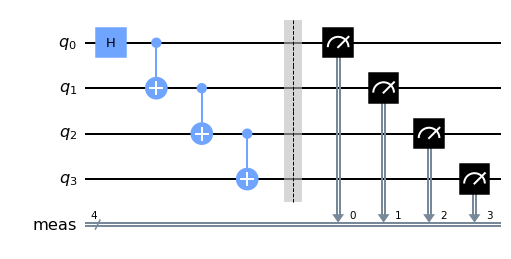

In [12]:
# Especificación del sistema, en este caso será un estado GHZ
n_qubits = 4                                   # cantidad de qubits
circ = QuantumCircuit(n_qubits)                # crear circuito

# Probar el circuito
circ.h(0)                                      # compuerta inicial del estado GHZ
for qubit in range(n_qubits - 1):              # agregar tantos CNOTs como qubits - 1
    circ.cx(qubit, qubit + 1)
circ.measure_all()                             # medir todos los qubits

circ.draw('mpl')                               # mostrar el circuito

<a id="secc2.1"></a>
## Simulación ideal

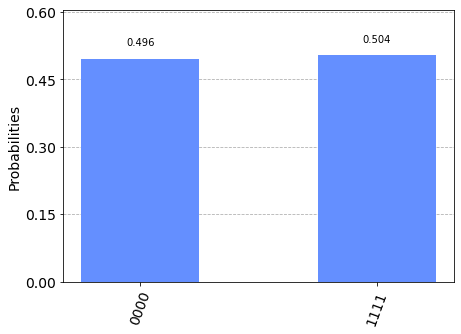

In [13]:
# Simulación ideal y su ejecución
sim_ideal = AerSimulator()

result_ideal = sim_ideal.run(circ).result()

plot_histogram(result_ideal.get_counts(0))

<a id="secc2.2"></a>
## Modelo básico de ruido para error de inversión de bits

Consideremos un ejemplo simple de juguete de modelo de ruido común en la investigación de la teoría de la información cuántica:

- Al aplicar una sola compuerta de un qubit, cambiar el estado del qubit con probabilidad `p_gate1`.
- Al aplicar una compuerta de 2 qubits, aplicar errores de un solo qubit a cada qubit.
- Al restablecer un qubit, restablecer a $1$ en lugar de $0$ con probabilidad `p_reset`.
- Al medir un qubit, cambiar el estado del qubit con probabilidad `p_meas`.

In [14]:
# Probabilidades de error de ejemplo
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# objetos QuantumError
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Agregar errores al modelo de ruido
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

# Mostrar la información del modelo de ruido
print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['reset', 'u2', 'measure', 'cx', 'u3', 'u1']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


Ahora ejecutemos la simulación ruidosa:

<div class="alert alert-block alert-danger">
Importante: Cuando se ejecutan simulaciones ruidosas, es fundamental transpilar el circuito para el backend para que el circuito se transpile con las compuertas base ruidosas correctas configuradas para el backend.

</div>

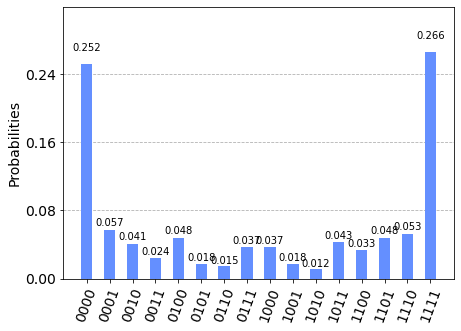

In [15]:
# Crear backend de simulador ruidoso
sim_noise = AerSimulator(noise_model=noise_bit_flip)                         # le indicamos el modelo de ruido

# Transpilamos el circuito para este simulador ruidoso en específico
circ_tnoise = transpile(circ, sim_noise)

# Ejecutar y obtener conteos
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Graficar los resultados con ruido
plot_histogram(counts_bit_flip)

<a id="secc2.3"></a>
## Modelo de relajación térmica $T_1\;/\;T_2$

Ahora consideremos un modelo de error más realista basado en la relajación térmica:

- Cada qubit está parametrizado por una constante de tiempo de relajación térmica $T_1$ y una constante de tiempo de desfase $T_2$.
- Toma en cuenta que debemos tener que $T_2\leq T_1$
- Las tasas de error en las instrucciones están determinadas por los tiempos de compuerta y los valores de qubit $T_1$, $T_2$.

In [16]:
# Valores de T1 y T2 para los qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4)      # Muestreado de la media de distribución normal 50 microsegundos
T2s = np.random.normal(70e3, 10e3, 4)      # Muestreado de la media de distribución normal 50 microsegundos



# Truncar de manera aleatoria T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Tiempos de instrucción (en nanosegundos)
time_u1 = 0                                # compuerta virtual
time_u2 = 50                               # pulso sencillo X90
time_u3 = 100                              # dos pulsos X90
time_cx = 300
time_reset = 1000                          # 1 microsegundo
time_measure = 1000                        # 1 microsegundo



# objetos QuantumError
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]


# Agregar los errores al modelo de ruido
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

# Mostrar información del modelo de ruido construido
print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['reset', 'u2', 'measure', 'cx', 'u3']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


Ahora ejecutemos la sumilación ruidosa:

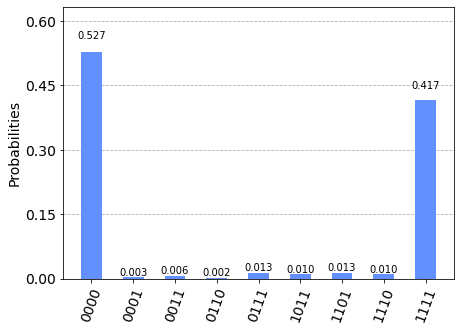

In [17]:
# Ejecutar la simulación ruidosa
sim_thermal = AerSimulator(noise_model=noise_thermal)                      # le indicamos el modelo de ruido

# Transpilamos el circuito para este simulador ruidoso en específico
circ_tthermal = transpile(circ, sim_thermal)

# Ejecutar y obtener conteos
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Graficar los resultados con ruido
plot_histogram(counts_thermal)

<a id="secc3"></a>
# Modelos de ruido obtenidos de los dispositivos reales

El módulo de ruido de Qiskit Aer es capaz de generar automáticamente un modelo de ruido básico a partir de un dispositivo de hardware IBMQ y utiliza este modelo para realizar simulaciones ruidosas de `QuantumCircuits` para estudiar los efectos de los errores que ocurren en dispositivos reales, sin tener que ejecutar nuestros circuitos ahí.

Ten en cuenta que estos modelos automáticos son solo una aproximación de los errores reales que ocurren en los dispositivos reales, debido al hecho de que deben construirse a partir de un conjunto limitado de parámetros de entrada relacionados con las tasas de error promedio en las compuertas. El estudio de errores cuánticos en dispositivos reales es un área activa de investigación.

Este modelo ruidoso generado a partir de un dispositivo real se logra usando la información de calibración reportada en el objeto `BackendProperties` de un dispositivo y tiene en cuenta:

- La probabilidad `gate_error` de cada compuerta base en cada qubit.
- `gate_length` de cada compuerta base en cada qubit.
- Las constantes de tiempo de relajación $T_1$, $T_2$ de cada qubit.
- La probabilidad de error de lectura de cada qubit.

<a id="secc3.1"></a>
## Backend de imitación de Terra

En Qiskit existen backends que son la **imitación** de dispositivos reales, que existen actualmente o que existieron en algún momento.

De estos es posible obtener sus datos de ruido real, para ello se utiliza la fecha almacenada en Qiskit Terra. Uno de ellos es el dispositivo `ibmq_vigo`.

In [18]:
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

Ahora construimos un circuito de prueba para comparar la salida del dispositivo real con la salida ruidosa simulada en el `AerSimulator` de Qiskit Aer. Prepararemos un estado GHZ de 3 qubits expresado como $\tfrac{1}{2}\left(\ket{000} + \ket{111}\right)$ en los qubits $0$, $1$ y $2$. Antes de ejecutar con ruido o en el dispositivo mostramos la salida ideal esperada sin ruido.

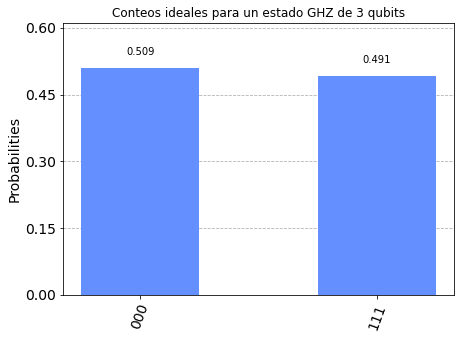

In [19]:
# Construir el circuito cuántico
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

sim_ideal = AerSimulator()

# Ejecutar y obtener conteos
result = sim_ideal.run(transpile(circ, sim_ideal)).result()
counts = result.get_counts(0)

# Mostrar resultados
plot_histogram(counts, title='Conteos ideales para un estado GHZ de 3 qubits')

Ahora generemos un simulador que imite un dispositivo. Para ello usamos el método `from_backend()`:

In [20]:
sim_vigo = AerSimulator.from_backend(device_backend)

sim_vigo

AerSimulator('aer_simulator(fake_vigo)'
             noise_model=<NoiseModel on ['sx', 'measure', 'cx', 'id', 'x']>)

Al almacenar las propiedades del dispositivo en `sim_vigo`, nos aseguramos de que se utilicen las compuertas base adecuadas y el mapa de acoplamiento al compilar circuitos para la simulación, imitando así de forma más precisa las compuertas que se ejecutarán en un dispositivo real. Además, `sim_vigo` contiene un modelo de ruido aproximado que consta de:

- Errores de compuerta de un solo qubit que consisten en un error de despolarización de un qubit seguido de un error de relajación térmica de un solo qubit.
- Errores de compuerta de dos qubits que consisten en un error de despolarización de dos qubits seguido de errores de relajación térmica de un solo qubit en ambos qubits de la compuerta.
- Errores de lectura de un solo qubit en el valor de bit clásico obtenido a partir de mediciones en qubits individuales.

Para los errores de compuerta, el parámetro de error de los errores de relajación térmica se deriva utilizando la función `thermal_relaxation_error` del módulo `aer.noise.errors`, junto con los parámetros individuales del qubit $T_1$ y $T_2$, y el parámetro `gate_time` de las propiedades del backend del dispositivo. La probabilidad del error de despolarización se establece entonces de modo que la falta de [fidelidad](https://www.fisicalab.com/apartado/medidas-precision#fidelidad) de la compuerta promedio combinada con el error de despolarización seguida de la relajación térmica sea igual al valor de error de la compuerta de las propiedades del backend.

Para los errores de lectura, la probabilidad de que el valor de bit clásico registrado se desvíe del resultado real después de una medición viene dada por el `qubit readout_errors`.

Ejecutemos el simulador de ruido:

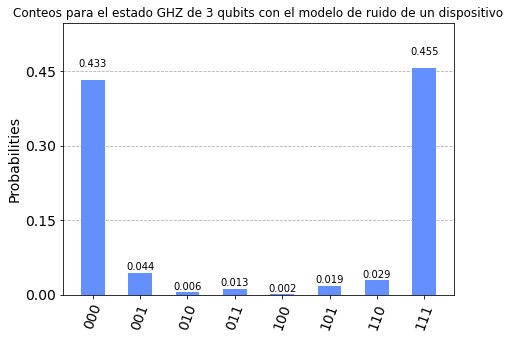

In [21]:
# Transpilar el circuito para las compuertas base ruidosas
tcirc = transpile(circ, sim_vigo)


# Ejecutar una simulación ruidosa y obtener los recuentos
result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)

plot_histogram(counts_noise, title="Conteos para el estado GHZ de 3 qubits con el modelo de ruido de un dispositivo")

Si se omite la transpilación, el ruido, del modelo de ruido del dispositivo, no se aplicará a las compuertas en el circuito que no están soportadas por el backend imitado, sin importar si están soportadas por el simulador.

**Nota**: Aquí utilizamos un simulador que imita un dispositivo real (mismas característias de ruido) por comodidad, pues de esta manera no necesitamos una cuenta de IBM Quantum Experience para ejecutar el contendio de este notebook. Tu puedes ejecutar tus circuitos al mimetizar el ruido de un dispositivo real, del mismo modo como lo hicimos con `sim_vigo`.

<br>

<div class="alert alert-block alert-success">

**Importante**

Es posible corregir los errores generados, ya sea de manera manual (personalizados) o al copiarlos de un dispositivo real, esto con ayuda de **Qiskit Ignis**, que es el módulo siguiente de este Taller.

</div>

<a id="secc4"></a>
# Referencias

- [1] Harper, R., Flammia, S.T. & Wallman, J.J. Efficient learning of quantum noise. Nat. Phys. 16, 1184–1188 (2020). https://doi.org/10.1038/s41567-020-0992-8
- [2] Stefano Bevacqua. History of supercomputing. Consultado en: https://www.eni.com/en-IT/technologies/history-of-supercomputing.html
- [3] HPC wire. Amazon Braket Introduces Quantum Circuit Noise Simulator, DM1. Consultado en : https://www.hpcwire.com/off-the-wire/amazon-braket-introduces-quantum-circuit-noise-simulator-dm1/
- [4] Qiskit Development team. Tutoriales: Building Noise Models. Consultado en: https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html
- [5] Qiskit Development team. Tutoriales: Device backend noise model simulations. Consultado en: https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html

<table width="100%">
    <tr style="background-color:white;">
        <td>
            <div style="text-align: left;">
            <a href="03_Dispositivo_Real.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                &lt;&lt; Notebook anterior: 03_Dispositivo_Real
            </a>
            </div>
        </td>
    </tr>
</table>